In [6]:
import os
import json
import tempfile
import requests
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [7]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) =  mnist.load_data()

In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [9]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [10]:
print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


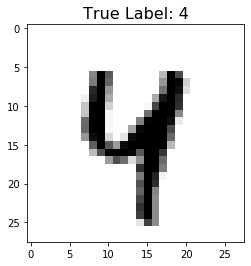

In [11]:
idx = 42
plt.imshow(test_images[idx].reshape(28, 28), cmap=plt.cm.binary)
plt.title(f'True Label: {test_labels[idx]}', fontdict={'size': 16})
plt.show()

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        input_shape=(28,28,1), filters=8, kernel_size=3,
        strides=2, activation='relu', name='Conv1'
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten_1 (Flatten)          (None, 1352)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               346368    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
Softmax (Dense)              (None, 10)                1290      
Total params: 380,634
Trainable params: 380,634
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(train_images, train_labels, epochs=epochs)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 9s 146us/sample - loss: 0.1967 - accuracy: 0.9418
Epoch 2/5
60000/60000 [==============================] - 9s 144us/sample - loss: 0.0976 - accuracy: 0.9691
Epoch 3/5
60000/60000 [==============================] - 9s 143us/sample - loss: 0.0831 - accuracy: 0.9746
Epoch 4/5
60000/60000 [==============================] - 9s 145us/sample - loss: 0.0719 - accuracy: 0.9765
Epoch 5/5
60000/60000 [==============================] - 9s 142us/sample - loss: 0.0659 - accuracy: 0.9791


In [15]:
results_eval = model.evaluate(test_images, test_labels, verbose=0)

for metric, value in zip(model.metrics_names, results_eval):
    print(metric + ': {:.3}'.format(value))

loss: 0.0919
accuracy: 0.972


In [16]:
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if(os.path.isdir(export_path)):
    print("\nAlready saved a model, cleaning up\n")
    !rm -r {export_path}
    
model.save(export_path, save_format="tf")

print(f"\nexport_path = {export_path}")
!ls -l {export_path}

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /var/folders/wh/h43cl57j4ljf1x5_4p1bqmx80000gn/T/1/assets

export_path = /var/folders/wh/h43cl57j4ljf1x5_4p1bqmx80000gn/T/1
total 232
drwxr-xr-x  2 shankar  staff      64 May  5 14:55 assets
-rw-r--r--  1 shankar  staff  114998 May  5 14:55 saved_model.pb
drwxr-xr-x  4 shankar  staff     128 May  5 14:55 variables


In [17]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defined Functions:
  Function Name: '__ca

In [18]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

tee: /etc/apt/sources.list.d/tensorflow-serving.list: No such file or directory
deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk1.8.0_131.jdk/Contents/Home/bin/apt" (-1)


In [ ]:
!apt-get install tensorflow-model-server

In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8051 --model_name=mym --model_base_path="${MODEL_DIR}" > server.log 2>&1

In [ ]:
!tail server.log

In [ ]:
data = json.dumps({
    "signature_name": "server_default",
    "instances": test_images[0:3].tolist()
})

In [ ]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/digits_model:predict', data=data, headers=headers)

predictions = json.loads(json_response.text)['predictions']

In [ ]:
plt.figure(figsize=(10, 15))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(test_images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.axis('off')
    color = 'green' if np.argmax(pedictions[i]) == test_labels[i] else 'red'
    plt.title(f'Prediction: {np.argmax(predictions[i])}\nTrue Label: {test_labels[i]}', color=color)
    
plt.show()